In [ ]:
# importing required packages...
!pip install -U -q segmentation-models
!pip install patchify
!pip install keras-tuner --upgrade



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
import cv2
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras import regularizers
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, Hyperband
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import get_custom_objects
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.optimizers import Adam
import keras_tuner
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D # import Cropping2D
from keras.applications import ResNet50 # import ResNet50
from glob import glob
import albumentations as A



Segmentation Models: using `tf.keras` framework.


C:\Users\bharghav\AppData\Local\Temp\ipykernel_16812\3839111315.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
sm.set_framework('tf.keras')

In [ ]:
from glob import glob

# Loading training and testing data 
train_data = glob("Cam101/train/*")
test_data = glob("Cam101/test/*")

In [ ]:
def list_image_paths(data):
    X_path = []
    Y_path = []
    for x in data:
        regex = x.find('_L')
        if regex == -1:
            x_split,_ = x.split('.')
            y = "".join([x_split,'_L.png'])
            X_path.append(x)
            Y_path.append(y)
    return X_path,Y_path

train_images,train_masks = list_image_paths(train_data)
val_images,val_masks = list_image_paths(test_data)

print(f"No. of samples in training data : {len(train_images)}")  
print(f"No. of samples in test data : {len(val_images)}")  
print(f"An example of an image path is: {train_images[0]}  ")

print(f"An example of a label path is: {train_masks[0]}  ")

No. of samples in training data : 90
No. of samples in test data : 11
An example of an image path is: Cam101/train\0016E5_07961.png  
An example of a label path is: Cam101/train\0016E5_07961_L.png  


Cam101/train\0016E5_07969.png


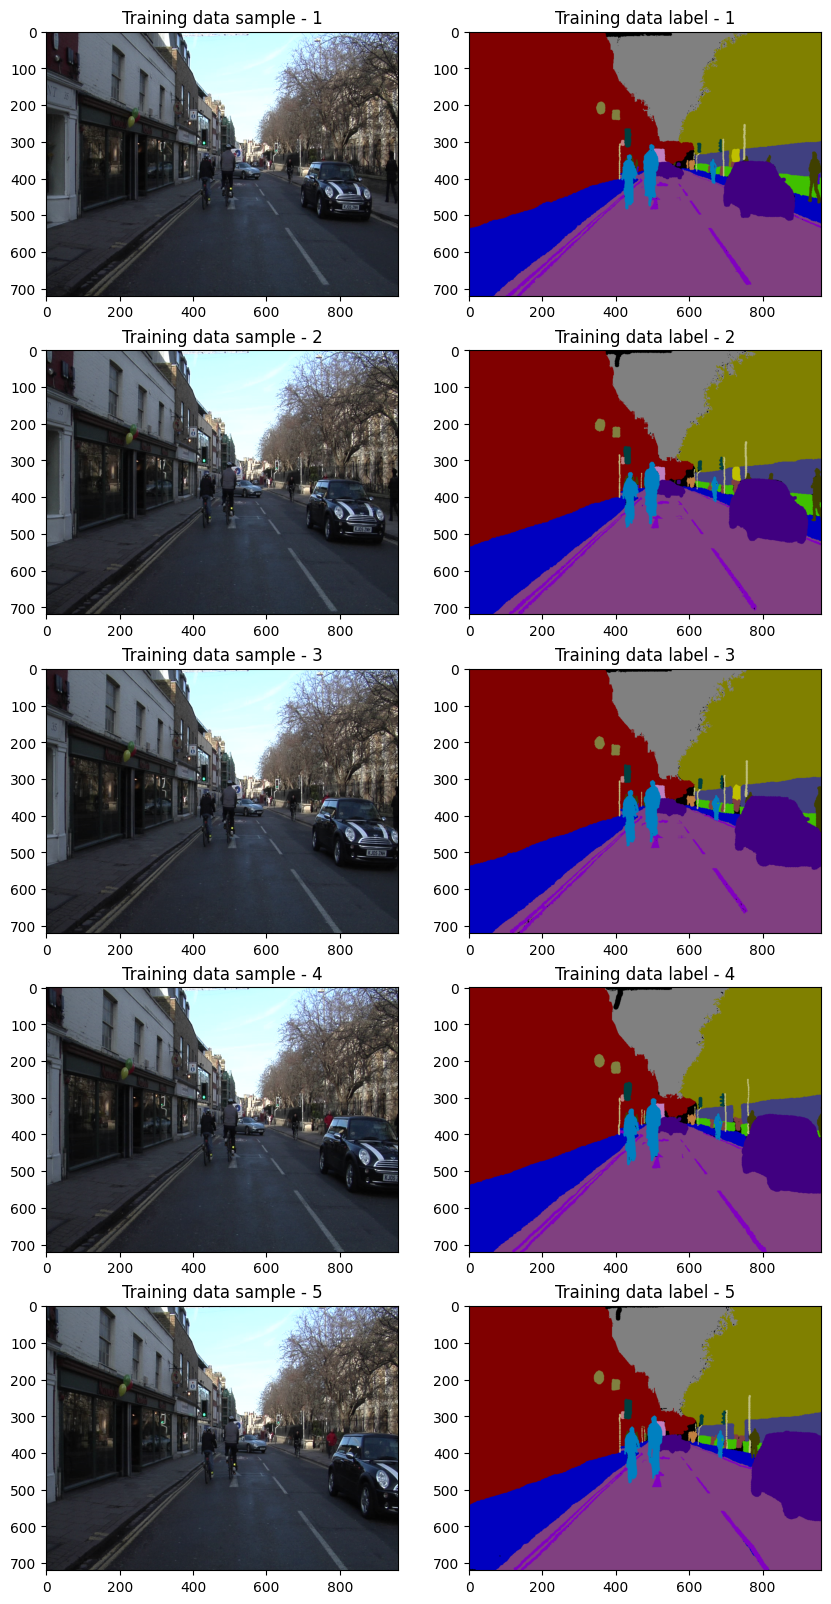

In [ ]:
# Visualisation
# Plotting 5 samples from training dataset
fig,ax = plt.subplots(5,2,figsize=(10,20))
count = 0
max_count = 5
for i in range(5):
  img = plt.imread(train_images[i])
  label = plt.imread(train_masks[i])
  ax[i][0].imshow(img)
  ax[i][0].title.set_text(f'Training data sample - {i+1}')
  ax[i][1].imshow(label)
  ax[i][1].title.set_text(f'Training data label - {i+1}')

In [ ]:
# Data augmentation using albumtations
# Exploration of  data augmentation techniques to expand the data in the training dataset.
import albumentations as A
X_train_expanded = []
Y_train_expanded = []

# Loading images
for i in range(len(train_images)):
  img_raw = cv2.imread(train_images[i],1)  
  img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
  label_raw = cv2.imread(train_masks[i],1)  
  label_raw = cv2.cvtColor(label_raw, cv2.COLOR_BGR2RGB)
  X_train_expanded.append(np.array(img_raw))
  Y_train_expanded.append(np.array(label_raw))

  # Defining augmentation pipeline
  transform = A.Compose([
      
      A.HorizontalFlip(p=1)
  ])

  # Apply the transformation to the train data and labels
  aug_img_arr = transform(image=np.array(img_raw))['image']
  aug_label_arr = transform(image=np.array(label_raw))['image']

  X_train_expanded.append(aug_img_arr)
  Y_train_expanded.append(aug_label_arr)


print(f"Train dataset samples after augmentation : {len(X_train_expanded)}")

Train dataset samples after augmentation : 180


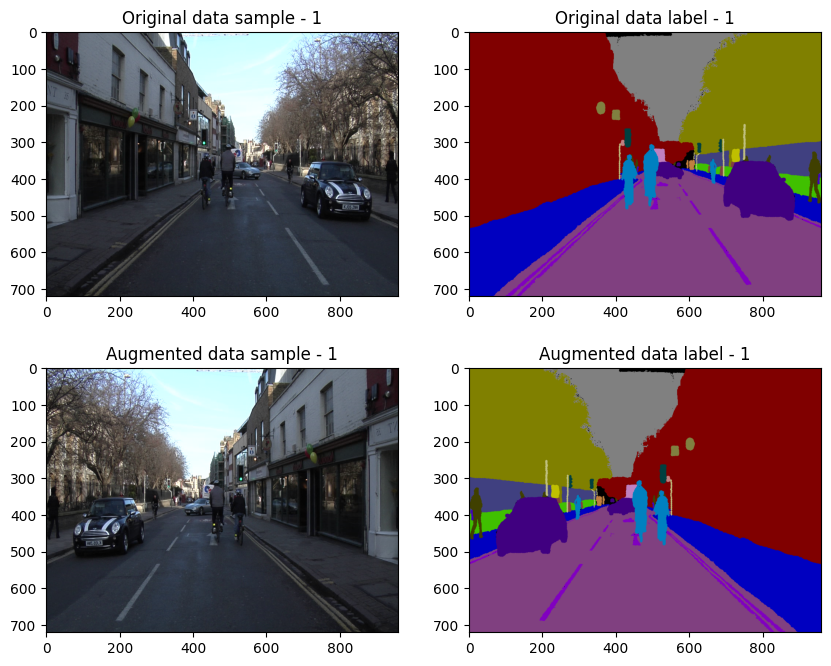

In [ ]:
# Visualisation
# Plotting 2 samples from augmented dataset
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax[0][0].imshow(X_train_expanded[0])
ax[0][0].title.set_text(f'Original data sample - {1}')
ax[0][1].imshow(Y_train_expanded[0])
ax[0][1].title.set_text(f'Original data label - {1}')

ax[1][0].imshow(X_train_expanded[1])
ax[1][0].title.set_text(f'Augmented data sample - {1}')
ax[1][1].imshow( Y_train_expanded[1])
ax[1][1].title.set_text(f'Augmented data label - {1}')

In [ ]:
def data_loader(file_list):
    # folder_dir = "../data/semantic_drone_dataset/training_set/images/"
    image_dataset = []
    for images in file_list:
        image = cv2.imread(images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (128, 128)) # comment out this line
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [ ]:
image_dataset = np.array(X_train_expanded[:15]) # real images...
test_image_dataset = data_loader(val_images)
mask_dataset = np.array(Y_train_expanded[:15]) # masked images...
test_mask_dataset = data_loader( val_masks)
test_mask_dataset = np.array(test_mask_dataset)

In [ ]:
import pandas as pd

# Define the column names
column_names = ['label', 'R', 'G', 'B']

# Create an empty list to store the rows of data
data = []

# Open the text file for reading
with open("Cam101/label_colors.txt", 'r') as f:
    # Iterate over each line in the file
    for line in f:
        # Split the line into columns
        columns = line.strip().split()
        
        # Extract the R, G, and B values
        r = int(columns[0])
        g = int(columns[1])
        b = int(columns[2])
        
        # Extract the name
        name = ' '.join(columns[3:])
        
        # Append a new row of data to the list
        data.append([name, r, g, b])

print(data)
# Create a DataFrame from the list of data
df = pd.DataFrame(data, columns=column_names)

# Display the resulting DataFrame
mask_labels = df
mask_labels

[['Animal', 64, 128, 64], ['Archway', 192, 0, 128], ['Bicyclist', 0, 128, 192], ['Bridge', 0, 128, 64], ['Building', 128, 0, 0], ['Car', 64, 0, 128], ['CartLuggagePram', 64, 0, 192], ['Child', 192, 128, 64], ['Column_Pole', 192, 192, 128], ['Fence', 64, 64, 128], ['LaneMkgsDriv', 128, 0, 192], ['LaneMkgsNonDriv', 192, 0, 64], ['Misc_Text', 128, 128, 64], ['MotorcycleScooter', 192, 0, 192], ['OtherMoving', 128, 64, 64], ['ParkingBlock', 64, 192, 128], ['Pedestrian', 64, 64, 0], ['Road', 128, 64, 128], ['RoadShoulder', 128, 128, 192], ['Sidewalk', 0, 0, 192], ['SignSymbol', 192, 128, 128], ['Sky', 128, 128, 128], ['SUVPickupTruck', 64, 128, 192], ['TrafficCone', 0, 0, 64], ['TrafficLight', 0, 64, 64], ['Train', 192, 64, 128], ['Tree', 128, 128, 0], ['Truck_Bus', 192, 128, 192], ['Tunnel', 64, 0, 64], ['VegetationMisc', 192, 192, 0], ['Void', 0, 0, 0], ['Wall', 64, 192, 0]]


,label,R,G,B
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [ ]:
# converting 3 values (RGB) to 1 label values...
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

In [ ]:
labels = []
test_labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)
for t in range(test_mask_dataset.shape[0]):
    test_label = rgb_to_labels(test_mask_dataset[t], mask_labels) # calling rgb to labels for each images...
    test_labels.append(test_label)

In [ ]:
"""
labels = np.array(labels)
test_labels = np.array(labels)
labels = np.expand_dims(labels, axis=3) # adding channel dim...
test_labels = np.expand_dims(labels, axis=3)
# print(len(labels))
# print(len(test_labels))
"""

'\nlabels = np.array(labels)\ntest_labels = np.array(labels)\nlabels = np.expand_dims(labels, axis=3) # adding channel dim...\ntest_labels = np.expand_dims(labels, axis=3)\n# print(len(labels))\n# print(len(test_labels))\n'

In [ ]:
n_classes = 32
n_test_classes = 32
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels...
test_labels_cat = to_categorical(test_labels, num_classes=n_test_classes) # one hot encoding the labels...


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_dataset[:20], labels_cat[:20], test_size = 0.10, random_state = 42) # train test split for data...


In [ ]:
X_test, y_test = np.array(test_image_dataset[:7]), np.array(test_labels_cat[:7])

In [ ]:
print("X_train",X_train.shape)
print('X_val',X_val.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

X_train (13, 720, 960, 3)
X_val (2, 720, 960, 3)
X_test (7, 720, 960, 3)
y_train (13, 720, 960, 32)
y_val (2, 720, 960, 32)
y_test (7, 720, 960, 32)


Fully Convolutional Network (FCN) with a ResNet50 backbone. The ResNet50 model is being used as a pre-trained feature extractor and its weights are frozen. The output layer is created for the FCN task with a 1x1 convolutional layer followed by upsampling layers

In [ ]:
# fcn architecture...
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D # import Cropping2D
from keras.applications import ResNet50 # import ResNet50

# define input shape
input_shape = (720, 960, 3) # change this from (128, 128, 3)

# define number of classes
num_classes = 32 # change this from 12

# load a pretrained model with ResNet50 backbone
pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# create output layer for fcn task
x = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(pretrained_model.output)
x = UpSampling2D((8, 8))(x) # keep this as (8, 8)
x = UpSampling2D((4, 4))(x) # keep this as (4, 4)
x = Cropping2D(((8, 8), (0, 0)))(x) # add this line to crop the output by 8 rows from top and bottom
outputs = x # remove this line

# create model
model = Model(inputs=pretrained_model.input, outputs=outputs)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# print model summary
model.summary()

# train the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 720, 960, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 726, 966, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 360, 480, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

The hyperparameter search is complete.
The optimal learning rate for the optimizer is 0.0032336344999961413.
L1 regularization: 0.0
L2 regularization: 0.0
Dropout: 0.5
Learning rate: 0.0032336344999961413
Optimizer: adam



Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.8091 - mean_io_u: 0.4453 - pixel_accuracy: 0.8345 - val_loss: 0.6407 - val_mean_io_u: 0.4818 - val_pixel_accuracy: 0.8725
Epoch 2/10
1/1 [==============================] - 1s 692ms/step - loss: 0.5993 - mean_io_u: 0.4474 - pixel_accuracy: 0.8776 - val_loss: 0.4714 - val_mean_io_u: 0.4825 - val_pixel_accuracy: 0.8934
Epoch 3/10
1/1 [==============================] - 1s 837ms/step - loss: 0.4446 - mean_io_u: 0.4483 - pixel_accuracy: 0.9004 - val_loss: 0.4128 - val_mean_io_u: 0.4825 - val_pixel_accuracy: 0.9034
Epoch 4/10
1/1 [==============================] - 1s 716ms/step - loss: 0.3862 - mean_io_u: 0.4502 - pixel_accuracy: 0.9093 - val_loss: 0.3760 - val_mean_io_u: 0.4833 - val_pixel_accuracy: 0.9088
Epoch 5/10
1/1 [==============================] - 1s 751ms/step - loss: 0.3391 - mean_io_u: 0.4529 - pixel_accuracy: 0.9141 - val_loss: 0.3615 - val_mean_io_u: 0.4848 - val_pixel_accuracy: 0.9034
Epoch 6/10
1/1 [=======

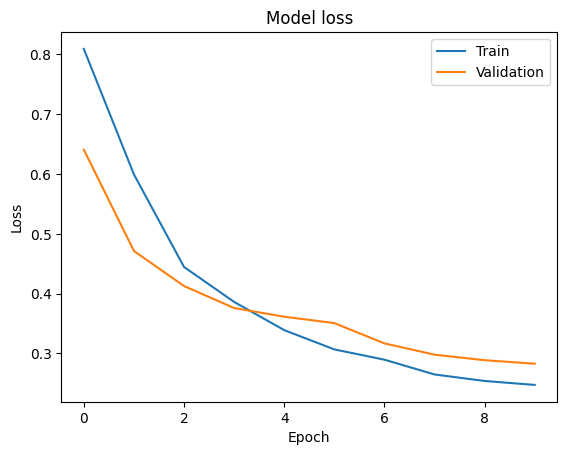

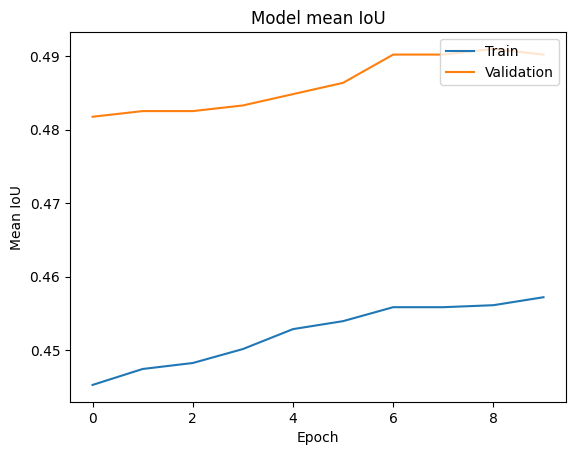

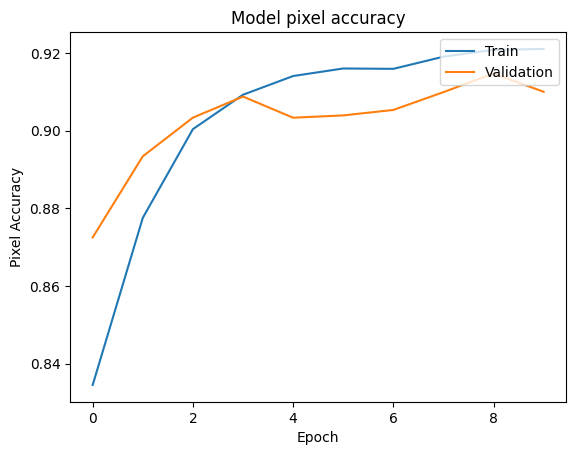

In [ ]:
!pip install keras-tuner --upgrade
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras import regularizers
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.optimizers import Adam

def pixel_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total_pixels = tf.reduce_sum(tf.ones_like(y_true))
    return correct_pixels / total_pixels

get_custom_objects().update({'pixel_accuracy': pixel_accuracy})

num_classes = 32 # Set this to the number of classes in your dataset
mean_iou = MeanIoU(num_classes=num_classes)

def weighted_pixel_cross_entropy(y_true, y_pred, class_weights):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    weight_map = tf.reduce_sum(class_weights * y_true, axis=-1)
    weighted_cross_entropy = tf.reduce_mean(cross_entropy * weight_map)
    return weighted_cross_entropy

def pixel_wise_cross_entropy(y_true, y_pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))


def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def pixel_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total_pixels = tf.cast(tf.reduce_sum(tf.ones_like(y_true)), tf.float32)
    return correct_pixels / total_pixels


def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # Reshape y_true and y_pred to flatten them
    y_true_focal = tf.reshape(y_true, [-1])
    y_pred_focal = tf.reshape(y_pred, [-1])

    # Calculate binary cross-entropy
    cross_entropy = tf.losses.binary_crossentropy(y_true_focal, y_pred_focal)

    # Calculate focal weights
    focal_weights = alpha * tf.pow(1.0 - y_pred_focal, gamma)

    # Apply focal weights to the cross-entropy
    focal_loss = focal_weights * cross_entropy

    # Compute the mean loss
    loss = tf.reduce_mean(focal_loss)

    return loss


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

from tensorflow.keras.utils import get_custom_objects
# add the custom focal_loss function to the custom object scope
get_custom_objects().update({'dice_coefficient': dice_coefficient})
get_custom_objects().update({'dice_loss': dice_loss})
get_custom_objects().update({'focal_loss': focal_loss})
get_custom_objects().update({'pixel_accuracy': pixel_accuracy})
get_custom_objects().update({'pixel_wise_cross_entropy': pixel_wise_cross_entropy})
get_custom_objects().update({'weighted_pixel_cross_entropy': weighted_pixel_cross_entropy})
num_classes = 32
# define a model-building function that takes an hp argument
def build_model(hp):
    inputs = tf.keras.Input(shape=(720, 960, 3))
    # load a pretrained model with ResNet50 backbone
    pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(720, 960, 3))
    # freeze the backbone layers
    pretrained_model.trainable = False
    # create output layer for fcn task
    x = pretrained_model(inputs)
    # x = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(pretrained_model.output)
    x = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same', kernel_regularizer=regularizers.l1_l2(l1=hp.Float('l1', 0.0, 0.01, step=0.01), l2=hp.Float('l2', 0.0, 0.01, step=0.01)))(x)
    x = tf.keras.layers.UpSampling2D((8, 8))(x) # keep this as (8, 8)
    x = tf.keras.layers.UpSampling2D((4, 4))(x) # keep this as (4, 4)
    x = tf.keras.layers.Cropping2D(((8, 8), (0, 0)))(x) # add this line to crop the output by 8 rows from top and bottom
    outputs = x

    # create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # choose optimizer and tune its parameters
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'),
            beta_1=hp.Float('beta_1', 0.8, 0.9, step=0.1),
            beta_2=hp.Float('beta_2', 0.99, 0.9999, step=0.0099),
            epsilon=hp.Float('epsilon', 1e-9, 1e-7, sampling='log')
        )
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'),
            momentum=hp.Float('momentum', 0.0, 0.9, step=0.3),
            nesterov=hp.Boolean('nesterov')
        )

    # compile model
    model.compile(optimizer=optimizer,
                  loss=hp.Choice('loss_function', ['categorical_crossentropy', 'weighted_pixel_cross_entropy', 'dice_loss', 'pixel_wise_cross_entropy']),
                  metrics=[hp.Choice('metric', ['accuracy', 'mean_iou', 'dice_coefficient', 'pixel_accuracy'])])

    # add a dropout layer and tune its rate
    x = tf.keras.layers.Dense(hp.Int('hidden_size',
                                      min_value=32,
                                      max_value=512,
                                      step=32))(x)
    x = tf.keras.layers.Dropout(hp.Float('dropout',
                                          min_value=0.0,
                                          max_value=0.5,
                                          default=0.25,
                                          step=0.25))(x)
    return model

# instantiate a tuner object with the appropriate search algorithm and objective
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# search for the best hyperparameters for the given model and data
tuner.search(X_train,y_train,epochs=10, validation_split=0.1)

# get the best hyperparameters and print them out
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
L1 regularization: {best_hps.get('l1')}
L2 regularization: {best_hps.get('l2')}
Dropout: {best_hps.get('dropout')}
Learning rate: {best_hps.get('learning_rate')}
Optimizer: {best_hps.get('optimizer')}
""")

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best optimizer and its parameters
best_optimizer = best_hps.get('optimizer')
if best_optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=best_hps.get('learning_rate'),
        beta_1=best_hps.get('beta_1'),
        beta_2=best_hps.get('beta_2'),
        epsilon=best_hps.get('epsilon')
    )
elif best_optimizer == 'sgd':
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=best_hps.get('learning_rate'),
        momentum=best_hps.get('momentum'),
        nesterov=best_hps.get('nesterov')
    )

# Compile the model with the best optimizer and metrics
best_model.compile(optimizer=optimizer,
                   loss='categorical_crossentropy',
                   metrics=[mean_iou, 'pixel_accuracy'])

# Fit the model on the training data
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_mean_iou, test_pixel_acc = best_model.evaluate(X_test, y_test)

print("Test mean IoU:", test_mean_iou)
print("Test pixel accuracy:", test_pixel_acc)


import matplotlib.pyplot as plt

# Plot the training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the mean IoU values
plt.plot(history.history['mean_io_u'])
plt.plot(history.history['val_mean_io_u'])
plt.title('Model mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the pixel accuracy values
plt.plot(history.history['pixel_accuracy'])
plt.plot(history.history['val_pixel_accuracy'])
plt.title('Model pixel accuracy')
plt.ylabel('Pixel Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



In [ ]:
# making predictions...
y_pred=best_model.predict(test_image_dataset)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(test_mask_dataset, axis=3)
print(len(test_image_dataset))

1/1 [==============================] - 2s 2s/step
2


In [ ]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, 1)
test_img = test_image_dataset[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (best_model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 118ms/step


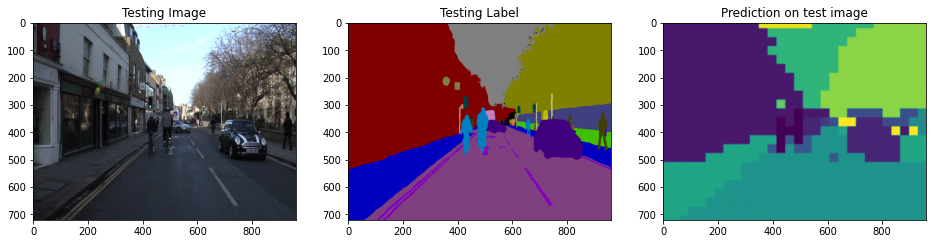

In [1]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

U-Net architecture with a ResNet50 backbone. It uses a pre-trained ResNet50 model as an encoder and a series of Conv2DTranspose layers as a decoder. The output of the ResNet50 model is upsampled and concatenated with the output of intermediate layers from the ResNet50 model using skip connections. The final output is produced by applying another Conv2DTranspose layer with a sigmoid activation function.


The hyperparameter search is complete. The optimal activation functions are elu, elu, elu and relu respectively for each layer. The optimal optimizer is adam.

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.7100 - mean_io_u_8: 0.5912 - pixel_accuracy: 0.8980 - val_loss: 1.0620 - val_mean_io_u_8: 0.5255 - val_pixel_accuracy: 0.8393
Epoch 2/10
1/1 [==============================] - 1s 908ms/step - loss: 0.9129 - mean_io_u_8: 0.4908 - pixel_accuracy: 0.8432 - val_loss: 0.7806 - val_mean_io_u_8: 0.5451 - val_pixel_accuracy: 0.8881
Epoch 3/10
1/1 [==============================] - 1s 715ms/step - loss: 0.6192 - mean_io_u_8: 0.5126 - pixel_accuracy: 0.8968 - val_loss: 0.5544 - val_mean_io_u_8: 0.5838 - val_pixel_accuracy: 0.9094
Epoch 4/10
1/1 [==============================] - 1s 834ms/step - loss: 0.4722 - mean_io_u_8: 0.5612 - pixel_accuracy: 0.9215 - val_loss: 0.6225 - val_mean_io_u_8: 0.6068 - val_pixel_accuracy: 0.9086
Epoch 5/10
1/1 [==========================

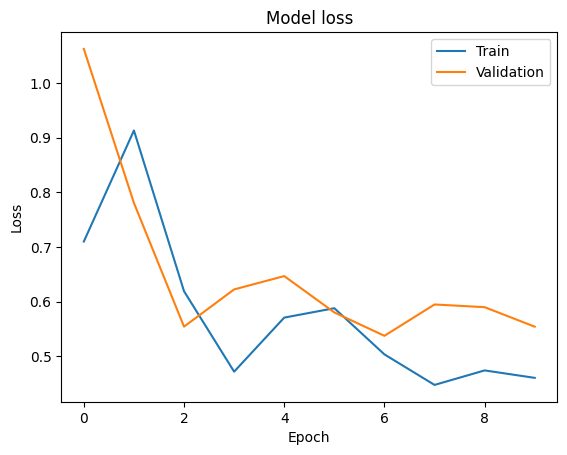

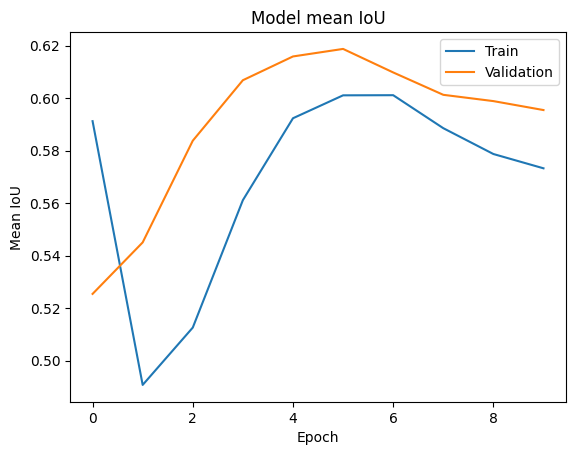

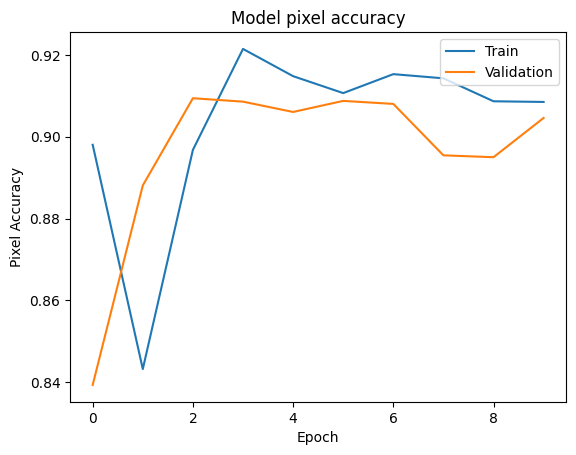

In [ ]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
import keras_tuner
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D # import Cropping2D
from keras.applications import ResNet50 # import ResNet50
from tensorflow.keras import layers


import tensorflow as tf

# resize X_train to (4, 512, 512, 3)
X_train_Unet = tf.image.resize(X_train, (512, 512))

# resize X_test to (1, 512, 512, 3)
X_test_Unet = tf.image.resize(X_test, (512, 512))

# resize y_train to (4, 512, 512, 32)
y_train_Unet = tf.image.resize(y_train, (512, 512))

# resize y_test to (1, 512, 512, 32)
y_test_Unet = tf.image.resize(y_test, (512, 512))


def pixel_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total_pixels = tf.cast(tf.reduce_sum(tf.ones_like(y_true)), tf.float32)
    return correct_pixels / total_pixels

get_custom_objects().update({'pixel_accuracy': pixel_accuracy})

def weighted_pixel_cross_entropy(y_true, y_pred, class_weights):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    weight_map = tf.reduce_sum(class_weights * y_true, axis=-1)
    weighted_cross_entropy = tf.reduce_mean(cross_entropy * weight_map)
    return weighted_cross_entropy

def pixel_wise_cross_entropy(y_true, y_pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))


def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # Reshape y_true and y_pred to flatten them
    y_true_focal = tf.reshape(y_true, [-1])
    y_pred_focal = tf.reshape(y_pred, [-1])

    # Calculate binary cross-entropy
    cross_entropy = tf.losses.binary_crossentropy(y_true_focal, y_pred_focal)

    # Calculate focal weights
    focal_weights = alpha * tf.pow(1.0 - y_pred_focal, gamma)

    # Apply focal weights to the cross-entropy
    focal_loss = focal_weights * cross_entropy

    # Compute the mean loss
    loss = tf.reduce_mean(focal_loss)

    return loss


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# add the custom focal_loss function to the custom object scope
get_custom_objects().update({'dice_coefficient': dice_coefficient})
get_custom_objects().update({'dice_loss': dice_loss})
get_custom_objects().update({'focal_loss': focal_loss})
get_custom_objects().update({'pixel_accuracy': pixel_accuracy})
get_custom_objects().update({'pixel_wise_cross_entropy': pixel_wise_cross_entropy})
get_custom_objects().update({'weighted_pixel_cross_entropy': weighted_pixel_cross_entropy})
get_custom_objects().update({'pixel_accuracy': pixel_accuracy})


class MyHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):
        get_custom_objects().update({'dice_coefficient': dice_coefficient})
        get_custom_objects().update({'dice_loss': dice_loss})
        get_custom_objects().update({'pixel_accuracy': pixel_accuracy})
        get_custom_objects().update({'pixel_wise_cross_entropy': pixel_wise_cross_entropy})
        get_custom_objects().update({'weighted_pixel_cross_entropy': weighted_pixel_cross_entropy})
        inputs = Input(shape=self.input_shape)
        pretrained_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
        x = pretrained_model.output

        # upsample the output using a series of conv2dtranspose and concatenate layers
        x = layers.Conv2DTranspose(512, 3, strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(hp.Choice('activation_1', values=['relu', 'elu']))(x)
        x = layers.Dropout(hp.Float('dropout_1', min_value=0.0,max_value=0.5, step=0.5))(x)
        x = layers.Concatenate()([x, pretrained_model.get_layer("conv4_block6_out").output])

        x = layers.Conv2DTranspose(256, 3, strides=2,padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(hp.Choice('activation_2', values=['relu', 'elu']))(x)
        x = layers.Dropout(hp.Float('dropout_2', min_value=0.0,max_value=0.5, step=0.5))(x)
        x = layers.Concatenate()([x, pretrained_model.get_layer("conv3_block4_out").output])

        x = layers.Conv2DTranspose(128, 3,strides=2,padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(hp.Choice('activation_3', values=['relu', 'elu']))(x)
        x = layers.Dropout(hp.Float('dropout_3', min_value=0.0,max_value=0.5, step=0.5))(x)
        x = layers.Concatenate()([x, pretrained_model.get_layer("conv2_block3_out").output])

        x = layers.Conv2DTranspose(64, 3,strides=2,padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(hp.Choice('activation_4', values=['relu', 'elu']))(x)
        x = layers.Dropout(hp.Float('dropout_4', min_value=0.0,max_value=0.5, step=0.5))(x)
        x = layers.Concatenate()([x, pretrained_model.get_layer("conv1_relu").output])

        # add an additional upsampling layer
        x = layers.Conv2DTranspose(64, 3,strides=2,padding="same")(x)

        outputs = layers.Conv2DTranspose(self.num_classes,
                                        3,
                                        strides=1,
                                        padding="same",
                                        activation="sigmoid")(x)

        model = Model(inputs=inputs,
                    outputs=outputs)

        optimizer_name = hp.Choice('optimizer', values=['adam', 'sgd'])
        
        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2, 1e-1])
    )
                
        elif optimizer_name == 'sgd':
            optimizer=tf.keras.optimizers.SGD(
                hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2, 1e-1])
            )
        
        model.compile(optimizer=optimizer,
              loss=hp.Choice('loss_function', ['categorical_crossentropy', 'weighted_pixel_cross_entropy', 'dice_loss', 'pixel_wise_cross_entropy']),
              metrics=[hp.Choice('metric', ['accuracy', 'mean_iou', 'dice_coefficient', 'pixel_accuracy']), mean_iou])

        
        for layer in model.layers:
            if isinstance(layer,
                        tf.keras.layers.Dense) or isinstance(layer,
                                                                tf.keras.layers.Conv2D) or isinstance(layer,
                                                                                                    tf.keras.layers.Conv2DTranspose):
                layer.add_loss(lambda: tf.keras.regularizers.l1_l2(
                    l1=hp.Float('l1', min_value=0.0,max_value=0.01, step=0.01),
                    l2=hp.Float('l2', min_value=0.0,max_value=0.01, step=0.01))(layer.kernel))

            if hasattr(layer,'bias_regularizer') and layer.use_bias:
                layer.add_loss(lambda: tf.keras.regularizers.l1_l2(
                    l1=hp.Float('l1', min_value=0.0,max_value=0.01, step=0.01),
                    l2=hp.Float('l2', min_value=0.0,max_value=0.01, step=0.01))(layer.bias))

        return model

hypermodel = MyHyperModel(input_shape=(512, 512, 3), num_classes=32)

tuner = RandomSearch(
    hypermodel,
    objective=keras_tuner.Objective('val_mean_io_u', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project'
)

tuner.search(X_train_Unet,y_train_Unet,batch_size=32,
             epochs=10,
             validation_data=(X_test_Unet,y_test_Unet))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal activation functions are {best_hps.get('activation_1')}, {best_hps.get('activation_2')}, {best_hps.get('activation_3')} and {best_hps.get('activation_4')} respectively for each layer. The optimal optimizer is {best_hps.get('optimizer')}.
""")

# Get the best optimizer and its parameters
best_optimizer = best_hps.get('optimizer')
if best_optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=best_hps.get('learning_rate')
    )
elif best_optimizer == 'sgd':
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=best_hps.get('learning_rate'),
        momentum=best_hps.get('momentum'),
        nesterov=best_hps.get('nesterov')
    )

# Compile the model with the best optimizer and metrics
best_model.compile(optimizer=optimizer,
                   loss='categorical_crossentropy',
                   metrics=[mean_iou, 'pixel_accuracy'])

# Fit the model on the training data
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.1)
print(history.history.keys())

# Evaluate the model on the test set
test_loss, test_mean_iou, test_pixel_acc = best_model.evaluate(X_test, y_test)

print("Test mean IoU:", test_mean_iou)
print("Test pixel accuracy:", test_pixel_acc)


import matplotlib.pyplot as plt

# Plot the training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the mean IoU values
plt.plot(history.history['mean_io_u_8'])
plt.plot(history.history['val_mean_io_u_8'])
plt.title('Model mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the pixel accuracy values
plt.plot(history.history['pixel_accuracy'])
plt.plot(history.history['val_pixel_accuracy'])
plt.title('Model pixel accuracy')
plt.ylabel('Pixel Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()




In [ ]:
# making predictions...
y_pred=best_model.predict(test_image_dataset)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(test_mask_dataset, axis=3)
print(len(test_image_dataset))

1/1 [==============================] - 1s 947ms/step
2


In [ ]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(test_image_dataset))
test_img = test_image_dataset[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (best_model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 42ms/step


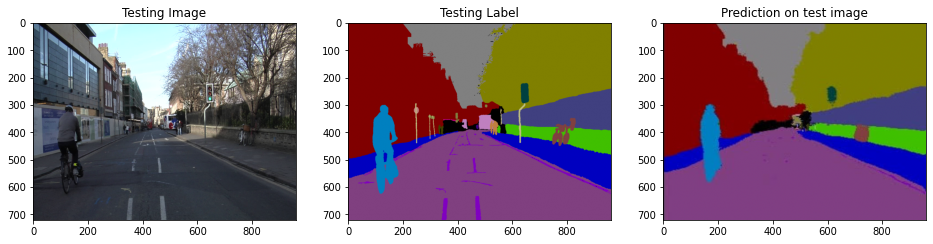

In [ ]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

DeepLabV3: 

In [ ]:
#deeplab architecture

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def PyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def deeplabV3Plus(input_shape , num_classes):
    model_input = keras.Input(shape=input_shape)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = PyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(720 // 4 // x.shape[1], 960 // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(720 // x.shape[1], 960 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
#hyperparameter
def pixel_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total_pixels = tf.cast(tf.reduce_sum(tf.ones_like(y_true)), tf.float32)
    return correct_pixels / total_pixels

get_custom_objects().update({'pixel_accuracy': pixel_accuracy})

def weighted_pixel_cross_entropy(y_true, y_pred, class_weights):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    weight_map = tf.reduce_sum(class_weights * y_true, axis=-1)
    weighted_cross_entropy = tf.reduce_mean(cross_entropy * weight_map)
    return weighted_cross_entropy

def pixel_wise_cross_entropy(y_true, y_pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))


def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # Reshape y_true and y_pred to flatten them
    y_true_focal = tf.reshape(y_true, [-1])
    y_pred_focal = tf.reshape(y_pred, [-1])

    # Calculate binary cross-entropy
    cross_entropy = tf.losses.binary_crossentropy(y_true_focal, y_pred_focal)

    # Calculate focal weights
    focal_weights = alpha * tf.pow(1.0 - y_pred_focal, gamma)

    # Apply focal weights to the cross-entropy
    focal_loss = focal_weights * cross_entropy

    # Compute the mean loss
    loss = tf.reduce_mean(focal_loss)

    return loss


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# add the custom focal_loss function to the custom object scope
get_custom_objects().update({'dice_coefficient': dice_coefficient})
get_custom_objects().update({'dice_loss': dice_loss})
get_custom_objects().update({'focal_loss': focal_loss})
get_custom_objects().update({'pixel_accuracy': pixel_accuracy})
get_custom_objects().update({'pixel_wise_cross_entropy': pixel_wise_cross_entropy})
get_custom_objects().update({'weighted_pixel_cross_entropy': weighted_pixel_cross_entropy})
get_custom_objects().update({'pixel_accuracy': pixel_accuracy})

mean_iou = MeanIoU(num_classes=32)

def build_model(hp):
    # Define the hyperparameters to tune
    activation = hp.Choice('activation', ['relu', 'sigmoid'])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    l1 = hp.Float('l1', min_value=0.0, max_value=0.1, step=0.01)
    l2 = hp.Float('l2', min_value=0.0, max_value=0.1, step=0.01)
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])



    model = deeplabV3Plus(input_shape=(720, 960, 3), num_classes=32)

    # Set the hyperparameters for the model
    # compile model
    model.compile(optimizer=optimizer,
                  loss=hp.Choice('loss_function', ['categorical_crossentropy']),
                  metrics=[hp.Choice('metric', ['accuracy', 'pixel_accuracy'])])

    return model

# Define the tuner and search space

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir_90',
    project_name='deeplab_90'
)


# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=2, validation_split=0.1)

# Get the best hyperparameters and model
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.values)
# Summary of the best model architecture
best_model.summary()


Trial 5 Complete [00h 11m 27s]
val_accuracy: 0.022235242649912834

Best val_accuracy So Far: 0.19426794350147247
Total elapsed time: 00h 55m 06s
INFO:tensorflow:Oracle triggered exit


Best Hyperparameters:
{'activation': 'relu', 'learning_rate': 0.01, 'l1': 0.08, 'l2': 0.01, 'dropout': 0.1, 'optimizer': 'sgd', 'loss_function': 'categorical_crossentropy', 'metric': 'accuracy'}
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 720, 960, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 726, 966, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 360, 480, 64  9472        ['conv1_pad[0][0]']           

In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.values)

Best Hyperparameters:
{'activation': 'relu', 'learning_rate': 0.01, 'l1': 0.08, 'l2': 0.01, 'dropout': 0.1, 'optimizer': 'sgd', 'loss_function': 'categorical_crossentropy', 'metric': 'accuracy'}


In [ ]:
best_model = tuner.hypermodel.build(best_hyperparameters)

# Compile the model with the best hyperparameters
best_model.compile(optimizer=best_hyperparameters['optimizer'],
                   loss=best_hyperparameters['loss_function'],
                   metrics=[best_hyperparameters['metric']])

# Train the model
history = best_model.fit(X_train, y_train, epochs=5, validation_split=0.1,batch_size=32)

Epoch 1/5
1/1 [==============================] - 338s 338s/step - loss: 4.2334 - accuracy: 0.0066 - val_loss: 10.4446 - val_accuracy: 0.1376
Epoch 2/5
1/1 [==============================] - 473s 473s/step - loss: 2.7013 - accuracy: 0.4052 - val_loss: 37.6051 - val_accuracy: 0.1892
Epoch 3/5
1/1 [==============================] - 477s 477s/step - loss: 1.3467 - accuracy: 0.7264 - val_loss: 43.6634 - val_accuracy: 0.1576
Epoch 4/5
1/1 [==============================] - 548s 548s/step - loss: 0.6715 - accuracy: 0.8667 - val_loss: 36.8832 - val_accuracy: 0.1780
Epoch 5/5
1/1 [==============================] - 394s 394s/step - loss: 0.4686 - accuracy: 0.9008 - val_loss: 30.5347 - val_accuracy: 0.1982


In [ ]:
# Evaluate the model on the test set
categorical_crossentropy, test_pixel_acc = model.evaluate(X_test, y_test)

print("categorical_crossentropy:", categorical_crossentropy)
print("Pixel accuracy:", test_pixel_acc)

1/1 [==============================] - 14s 14s/step - loss: 26.3448 - accuracy: 0.2178
categorical_crossentropy: 26.34482192993164
Pixel accuracy: 0.21775731444358826


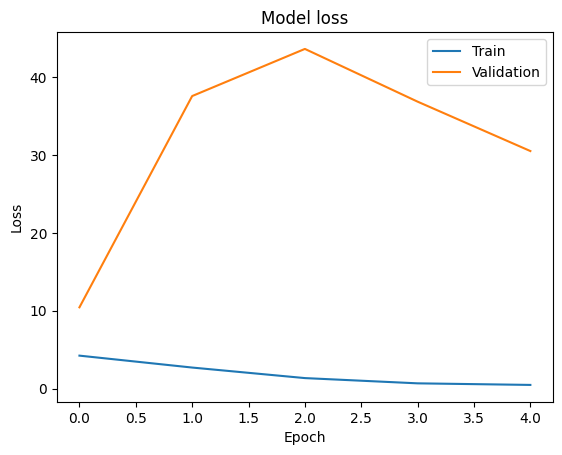

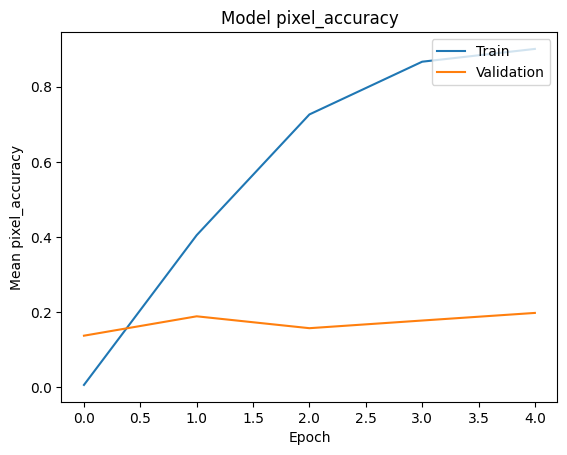

In [ ]:
# Plot the training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the mean IoU values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model pixel_accuracy')
plt.ylabel('Mean pixel_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()




In [ ]:
y_pred=best_model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_train, axis=3)


1/1 [==============================] - 25s 25s/step


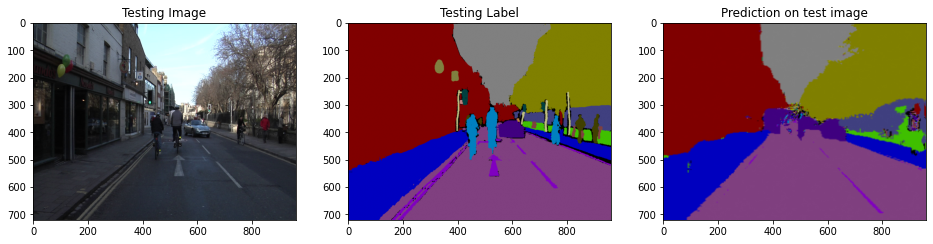

In [ ]:
# Plotting 5 samples from training dataset


y_pred_argmax=np.argmax(y_pred, axis=3)[i,:,:]
y_test_argmax=np.argmax(y_train, axis=3)[i,:,:]

# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(X_train[i])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(y_test_argmax)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(y_pred_argmax)
plt.show()